# Measure invariance to rotations in a custom CNN

Using PyTorch, we will define a custom CNN, train it with MNIST, and afterwards measure its invariance with respect to rotations on that dataset.


First, we install the `tmeasures` library, as well as other `poutyne` to simplify training and `scikit-learn` for some goodies.

We also define the compute device and the path to store data and results.

In [1]:
#!pip install tmeasures poutyne scikit-learn
%load_ext autoreload
%autoreload 2
import torch 
from pathlib import Path

torch.manual_seed(0)
from tempfile import TemporaryDirectory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_path = Path(TemporaryDirectory().name)/"tm_example_pytorch"
results_path.mkdir(parents=True, exist_ok=True)
print(f"Saving results to {results_path}")

Saving results to /tmp/tmp3dkvnays/tm_example_pytorch


# Define a vanilla PyTorch CNN model

In this case we will define simple model with 2 blocks of Conv2D-ReLU-MaxPool2D and then two linear layers.


In [2]:
from torch import nn


class Flatten(nn.Module):
    def forward(self, input: torch.Tensor):
        return input.view(input.size(0), -1)

# Model definition
class CNN(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        c, h, w = shape
        h_flat, w_flat = h // 4, w // 4
        filters = 32
        filters2 = filters * 2
        flat = h_flat * w_flat * filters2
        self.model = nn.Sequential(
            nn.Conv2d(c, filters, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(filters, filters2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Flatten(),
            nn.Linear(flat, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=-1),
        )

    # forward works as normal
    def forward(self, x):
        return self.model.forward(x)


# Train model with MNIST and rotation transformations for data augmentation

Use the `torchvision` class MNIST to download and perform data augmentation on the samples of MNIST, both for training and testing sets. Then use `pouytine` to train the model.

You can modify the variable `degree_range` to increase or decreaes the strength of the transformations, and hence of the invariance obtained by the model while training.

In [3]:
from torchvision import transforms, datasets
from poutyne import Model

base_preprocessing = [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]
# Rotation data augmentation
# CHANGE THIS VARIABLE from 0 to 180 to train with different intensities of data augmentation
# More data augmentation will cause the network to be more invariant
degree_range = 180  # train with random rotations from -degree_range to degree_range
train_augmentation = [transforms.RandomRotation(degree_range)]
train_transform = transforms.Compose(train_augmentation + base_preprocessing)
measure_transform = transforms.Compose(base_preprocessing)
path = Path('~/.datasets/mnist').expanduser()
path.mkdir(exist_ok=True,parents=True)

train_dataset = datasets.MNIST(path, train=True, download=True,
                                transform=train_transform)
test_dataset = datasets.MNIST(path, train=False,
                              transform=train_transform)


# TRAIN

model = CNN((1, 28, 28))
poutyne_model = Model(model,
                      optimizer='adam',
                      loss_function='cross_entropy',
                      batch_metrics=['accuracy'],
                      device=device)
poutyne_model.fit_dataset(train_dataset, test_dataset, epochs=10, batch_size=128,num_workers=2  ,dataloader_kwargs={"pin_memory":True})



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.49MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 192kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.81MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 6.37MB/s]


Epoch:  1/10 Train steps: 469 Val steps: 79 28.39s loss: 0.663023 acc: 78.418333 val_loss: 0.348116 val_acc: 88.760000
Epoch:  2/10 Train steps: 469 Val steps: 79 25.52s loss: 0.268448 acc: 91.576667 val_loss: 0.204921 val_acc: 93.480000
Epoch:  3/10 Train steps: 469 Val steps: 79 25.77s loss: 0.197681 acc: 93.795000 val_loss: 0.167652 val_acc: 94.750000
Epoch:  4/10 Train steps: 469 Val steps: 79 26.51s loss: 0.166078 acc: 94.876667 val_loss: 0.149321 val_acc: 95.290000
Epoch:  5/10 Train steps: 469 Val steps: 79 26.70s loss: 0.144576 acc: 95.475000 val_loss: 0.129732 val_acc: 96.020000
Epoch:  6/10 Train steps: 469 Val steps: 79 26.42s loss: 0.132058 acc: 95.866667 val_loss: 0.112435 val_acc: 96.310000
Epoch:  7/10 Train steps: 469 Val steps: 79 26.74s loss: 0.120505 acc: 96.258333 val_loss: 0.120348 val_acc: 96.160000
Epoch:  8/10 Train steps: 469 Val steps: 79 26.24s loss: 0.112364 acc: 96.520000 val_loss: 0.109152 val_acc: 96.570000
Epoch:  9/10 Train steps: 469 Val steps: 79 27.1

[{'epoch': 1,
  'time': 28.38910005100479,
  'loss': 0.6630229221185049,
  'acc': np.float64(78.41833334147135),
  'val_loss': 0.34811581926345825,
  'val_acc': np.float64(88.76)},
 {'epoch': 2,
  'time': 25.52372547800769,
  'loss': 0.26844849865436554,
  'acc': np.float64(91.57666665852865),
  'val_loss': 0.20492125247716902,
  'val_acc': np.float64(93.48)},
 {'epoch': 3,
  'time': 25.76907006801048,
  'loss': 0.19768076707522075,
  'acc': np.float64(93.79500000813802),
  'val_loss': 0.16765177278518678,
  'val_acc': np.float64(94.75)},
 {'epoch': 4,
  'time': 26.5058946210047,
  'loss': 0.16607841816743216,
  'acc': np.float64(94.87666665852865),
  'val_loss': 0.14932081258893012,
  'val_acc': np.float64(95.29)},
 {'epoch': 5,
  'time': 26.696864108002046,
  'loss': 0.14457554228703182,
  'acc': np.float64(95.47500000813803),
  'val_loss': 0.1297323048815131,
  'val_acc': np.float64(96.02)},
 {'epoch': 6,
  'time': 26.424659245996736,
  'loss': 0.13205838358402253,
  'acc': np.float

# Measure model's invariance  to rotations

To measure the model's invariance, we require three things:

1. A version of the dataset, without labels and reduced in size to reduce computation.
2. A discrete and finite set of transformations 
3. The model itself, with access to intermediate values or activations

Afterwards, we can create an Invariance Measure and compute it with these elements.

# 1. Dataset

Since the invariance measure do not use the labels of the dataset, we will create a custom MNIST dataset which does not return labels, only samples.

Also, since the invariance measure does not require large sample sizes, we will subsample the test set of mnist to obtain a reduced sample and reduce computation time.



In [6]:
class MNIST(datasets.MNIST):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return x
dataset_nolabels = MNIST(path, train=False, download=True, transform=measure_transform)


# Subsample 
N = 1000
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices, _ = train_test_split(np.arange(len(dataset_nolabels)), train_size=N, stratify=dataset_nolabels.targets,random_state=0)
dataset_nolabels = Subset(dataset_nolabels, indices)



# 2. Transformations

While `torchvision.transforms` provides ready-made transformations, in this case we will have to roll our own, since we have to define a finite set of transformations. Luckily, `tmeasures` has already define some sets of transformations for us, including rotations. In this case, we are using `n=128` transformations, with angles sampled uniformly from `0.0` (0º) to `1.0` (360º).

In [28]:

# Create a set of rotation transformations
from tmeasures.transformations.parameters import UniformRotation
from tmeasures.pytorch.transformations.affine import AffineTransformationSet

rotation_parameters = UniformRotation(n=128, angles=1.0)
transformations = AffineTransformationSet(r=rotation_parameters)

# 3. Model

PyTorch works with `nn.Module` objects that provide a `forward` method. The invariance measures, however, requiere not just the result(s) of the `forward` method but the result of the intermediate values or activations used to compute the final output(s). 

While it would be possible to modify a `nn.Module` defined model to return all of its activations, this would be cumbersome and difficult to manage since when training/testing we would require the *usual* `forward`, and when computing the measure we would require the new `forward`.

Therefore, measures in `tmeasures` require a model that implements the `ActivationsModule` interface with just two methods: `forward_activations` and `activation_names`. While implementing these methods allow you to best decide which activations are selected and how they are used, they can be cumbersome to define and mantain, specially when actively modifying a model.

Luckily, the `AutoActivationsModule` can take an unmodified `nn.Module` and automatically implement these methods using [forward hooks](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html).



In [29]:
import tmeasures as tm

# Put the model in evaluation mode
model.eval()

# Create an ActivationsModule from the vanilla model
# Use AutoActivationsModule to automatically to evaluate the measure on all modules
activations_module = tm.pytorch.AutoActivationsModule(model)


# Computing the measure

Last step before computing the measure: we need to define a PyTorchMeasureOptions object to configure where and the measure will be computed. The `batch_size` and `num_workers` keywords are analogous to the ones used in [PyTorch's DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

The `data_device`, `model_device` and `measure_device`   indicate, respectively, where the transformations and data preprocessing are performed, where the activations of the model are computed, and finally where the actual measure is computed. In most cases, using the same device in all cases will have the most performance; however, in some cases it is necessary or desirable to perform data preprocessing in `cpu` and model and measure computations in a `gpu` or other accelerator.

Finally, we can `eval` the measure with the dataset, transformation, model and options, obtaining a `PyTorchMeasureResult`, which can be handily converted to a `numpy` version for easy visualization.


In [30]:
# Define options for computing the measure
options = tm.pytorch.PyTorchMeasureOptions(batch_size=128, num_workers=0,model_device=device,measure_device=device,data_device="cpu")

# Define the measure and evaluate it
measure = tm.pytorch.NormalizedVarianceInvariance()
measure_result:tm.pytorch.PyTorchMeasureResult = measure.eval(dataset_nolabels,transformations,activations_module,options)
measure_result = measure_result.numpy()

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

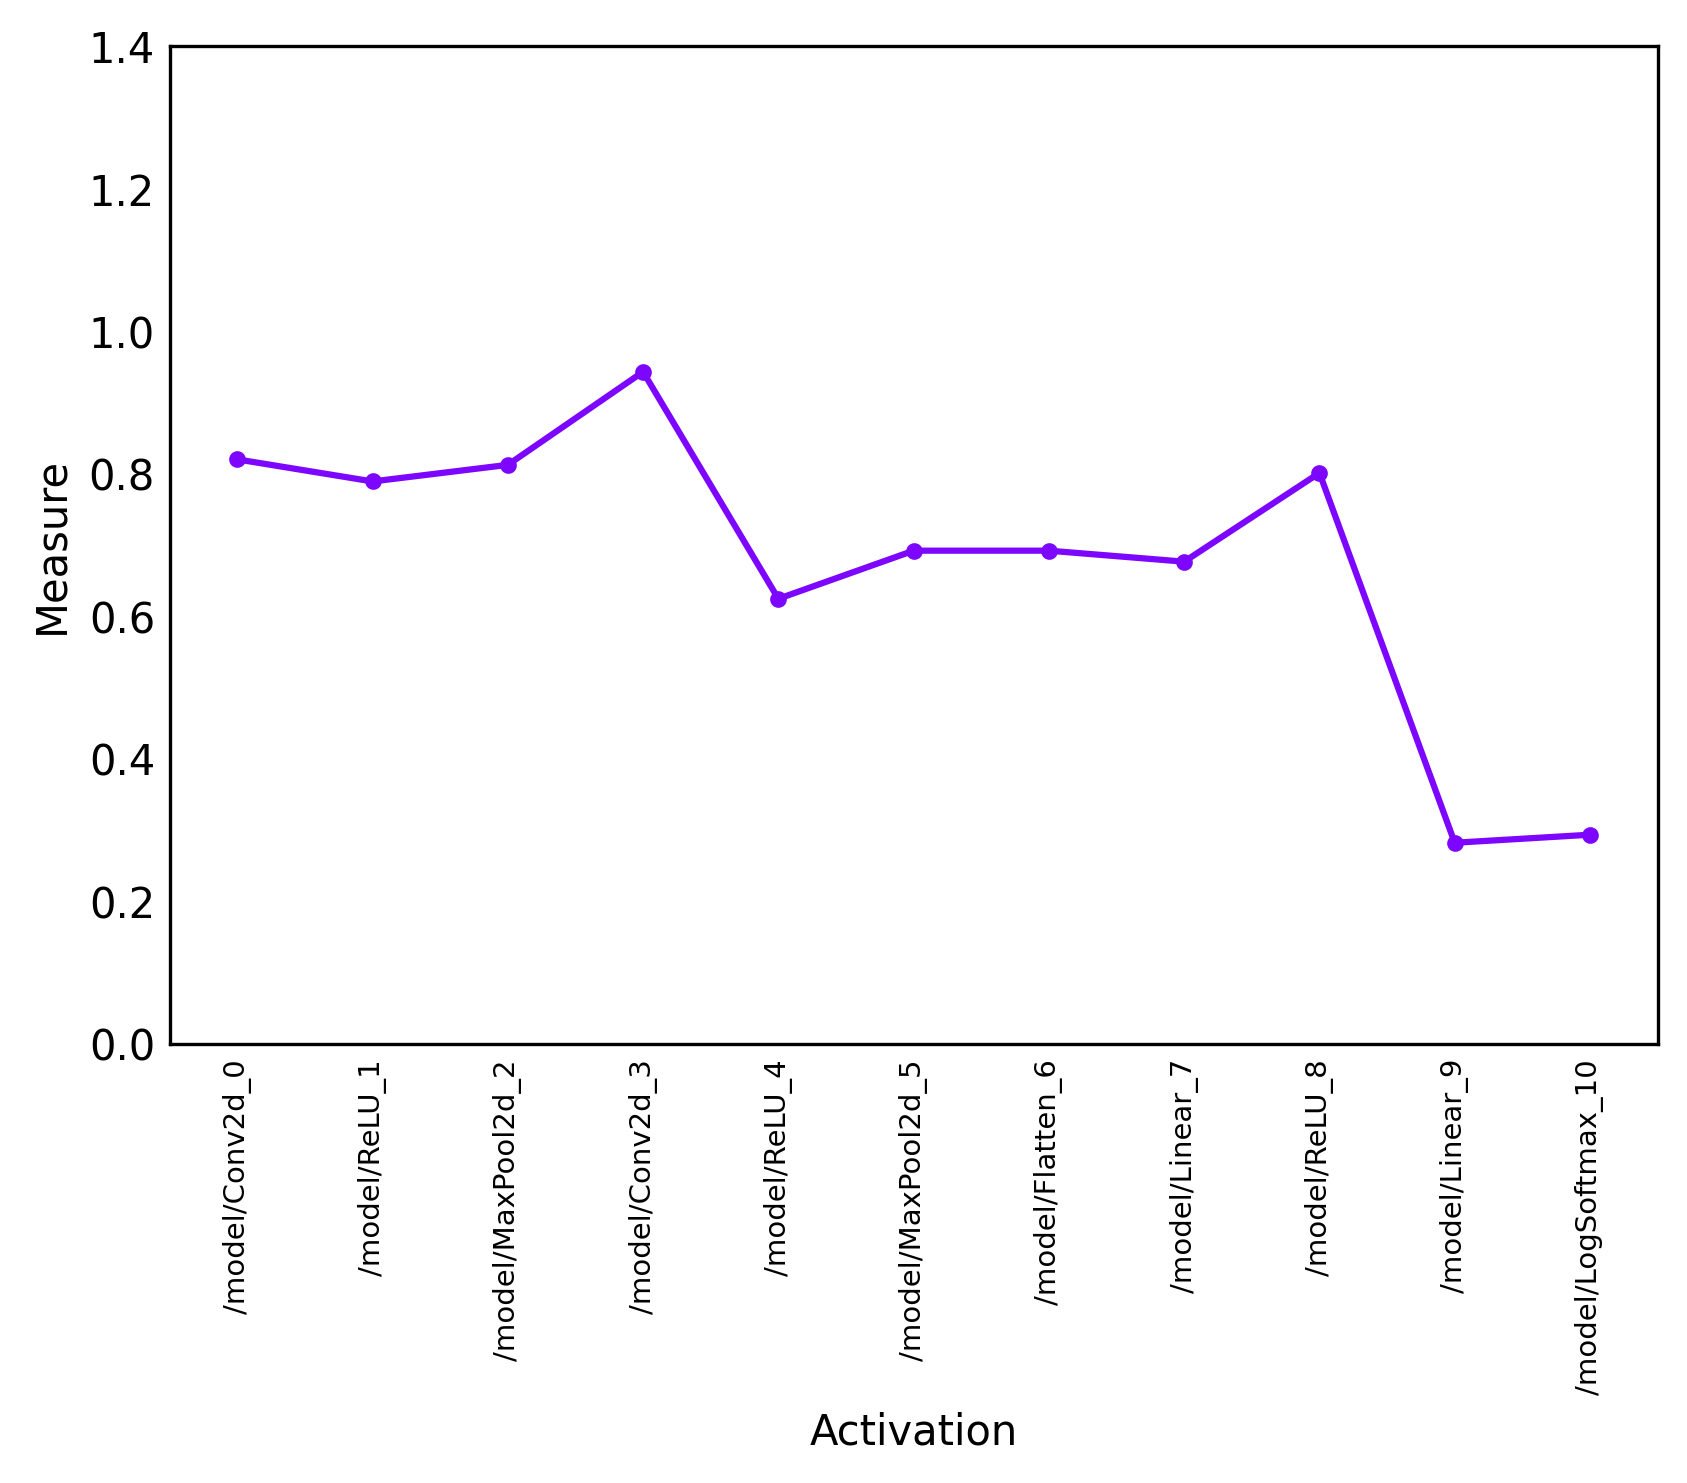

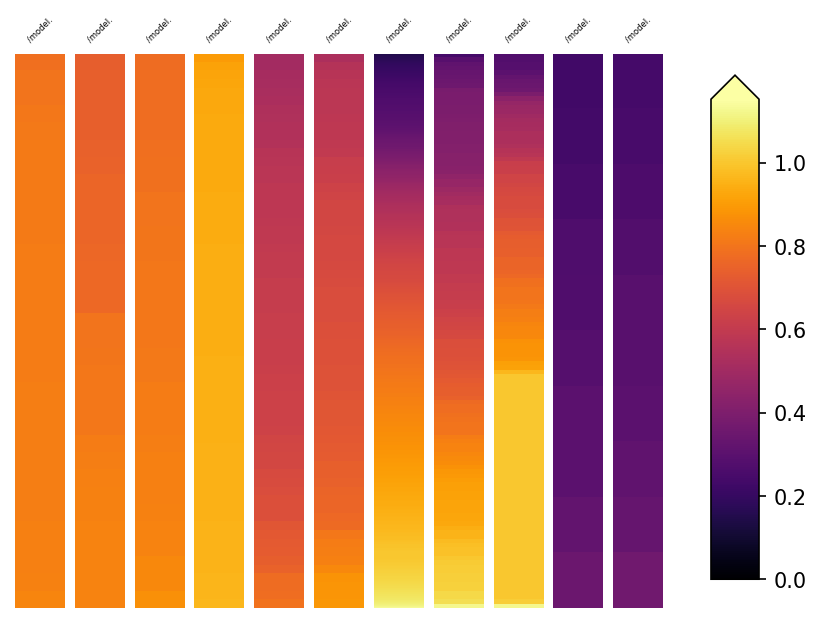

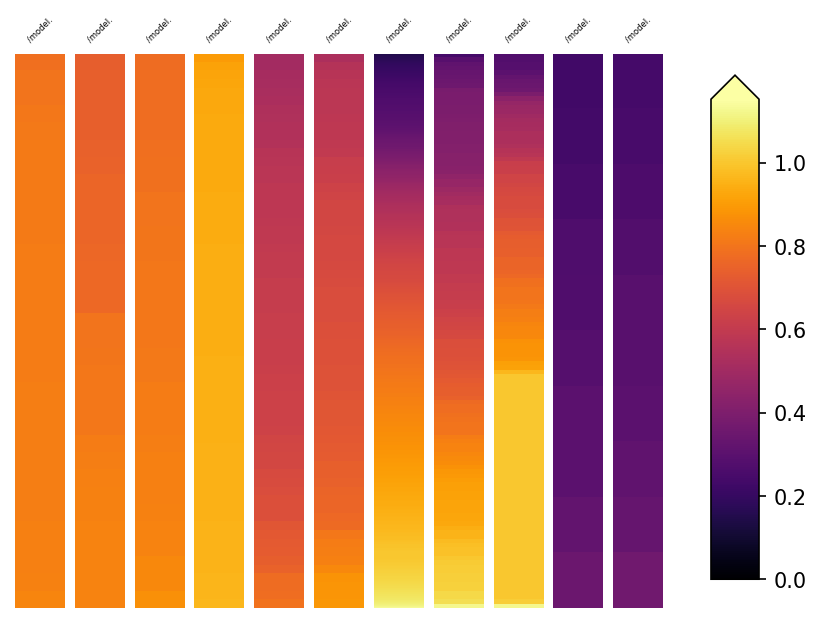

In [32]:
import matplotlib.pyplot as plt
tm.visualization.plot_average_activations(measure_result)
plt.show()
tm.visualization.plot_heatmap(measure_result)
